In [ ]:
import datasets

dataset = datasets.load_dataset("UCSC-VLAA/Recap-COCO-30K")

import os

def save_image_and_get_path(example, save_dir):
    # Create a unique filename
    filename = f"{example['image_id']}_{hash(example['image_id'])}.jpg"
    filepath = os.path.join(save_dir, filename)
    
    # Save the image
    example['image'].save(filepath)
    
    # Add the filepath to the example
    example['image_filepath'] = filepath
    
    return example

def process_dataset(dataset, save_dir):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Apply the save_image_and_get_path function to each example
    return dataset.map(lambda example: save_image_and_get_path(example, save_dir))

# Specify the directory where you want to save the images
save_directory = "./saved_images_coco_30k/"

# Process the dataset
dataset = process_dataset(dataset, save_directory)

In [ ]:
dataset['train']

In [15]:
import numpy as np

np.random.seed(0)
NUM_SAMPLES = 1000
# select 100 random image index values
sample_idx = np.random.randint(0, len(dataset)+1, NUM_SAMPLES).tolist()
# extract the image sample from the dataset
# images = [dataset['train'][i]['image'] for i in sample_idx]

# extract all images from the dataset
images = [dataset['train'][i]['image'] for i in range(len(dataset['train']))]

In [16]:
len(images)

30504

In [17]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

from tqdm.auto import tqdm

batch_size = 128
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)

  0%|          | 0/239 [00:00<?, ?it/s]

In [18]:
image_arr.shape


(30504, 512)

In [19]:
image_arr.min(), image_arr.max()


(-10.407335, 4.4831057)

In [20]:
np.linalg.norm(image_arr, axis=1).shape

(30504,)

In [21]:
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)
image_arr.min(), image_arr.max()

(-0.81437135, 0.4220226)

In [22]:
prompt = "a dog in the snow"

# create transformer-readable tokens
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)

text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr)
scores.shape

(1, 30504)

In [23]:
top_k = 10
# get the top k indices for most similar vecs
idx = np.argsort(-scores[0])[:top_k]
idx

array([15716, 28392, 13122, 20030, 25379, 22046, 27456,  5408,  3309,
        1485])

15716: 2.4165878295898438


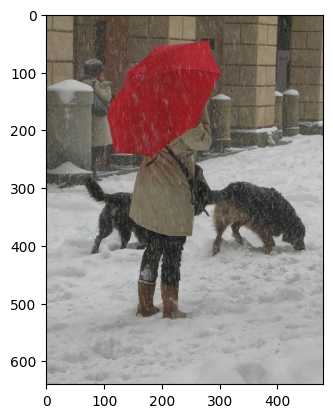

28392: 2.363708972930908


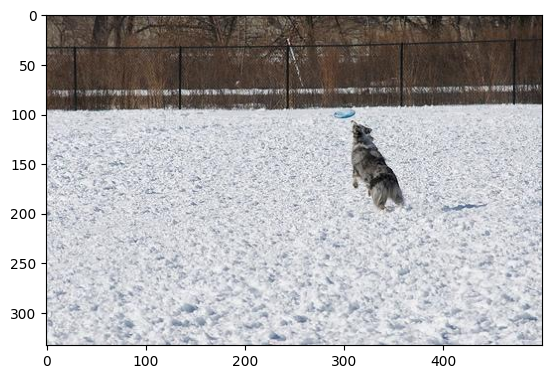

13122: 2.3418681621551514


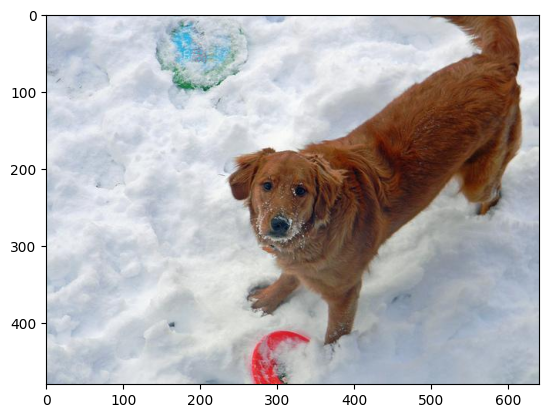

20030: 2.33601713180542


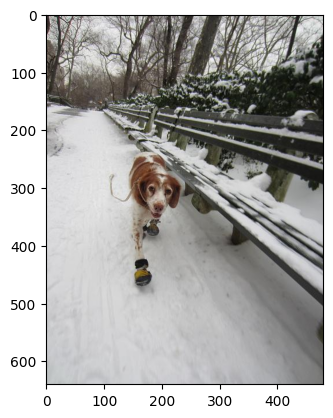

25379: 2.3271067142486572


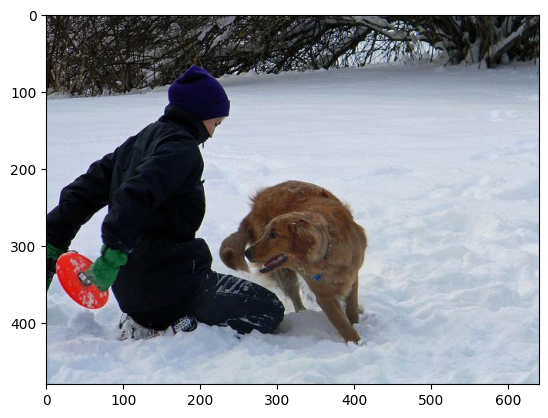

22046: 2.3165125846862793


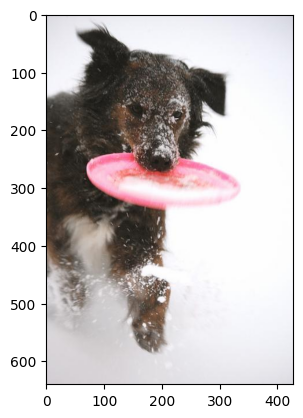

27456: 2.2901625633239746


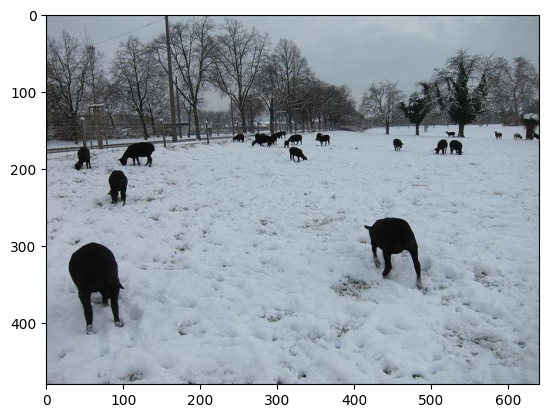

5408: 2.289917469024658


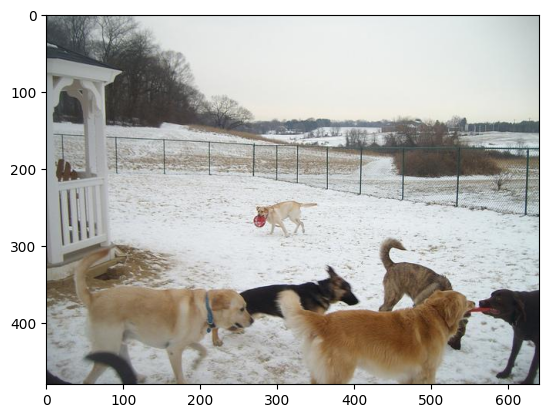

3309: 2.283750057220459


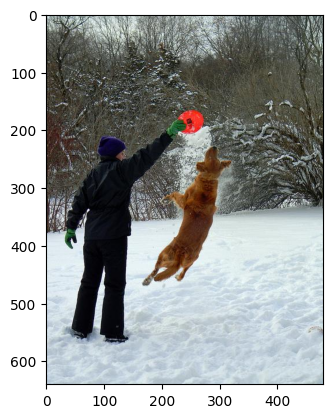

1485: 2.246068239212036


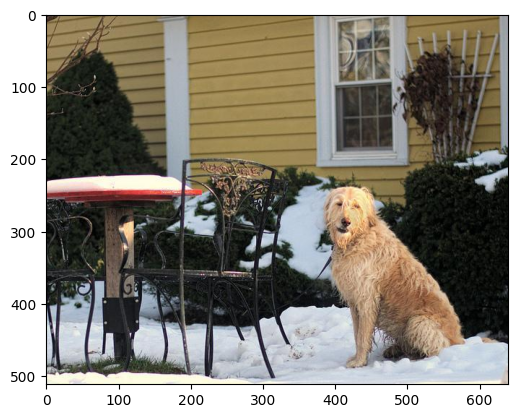

In [24]:
import matplotlib.pyplot as plt

# display the results
for i in idx:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()

In [27]:
df = dataset['train'].to_pandas()
df = df.drop(columns=['image'])
df

,image_id,coco_url,caption,recaption,image_filepath
0,53120,http://images.cocodataset.org/val2014/COCO_val...,Several horses with riders crossing a body of ...,A group of people is riding horses along a san...,./saved_images_coco_30k/53120_53120.jpg
1,325873,http://images.cocodataset.org/val2014/COCO_val...,A woman and a child sit on the floor and inter...,A woman and a young child are sitting on the f...,./saved_images_coco_30k/325873_325873.jpg
2,217937,http://images.cocodataset.org/val2014/COCO_val...,There is an open face sandwich and a fork on t...,"A plate of food with a fried egg on top, surro...",./saved_images_coco_30k/217937_217937.jpg
3,196865,http://images.cocodataset.org/val2014/COCO_val...,a pillow a bed a table and two books,A book titled 'SVG Essentials' is lying on a n...,./saved_images_coco_30k/196865_196865.jpg
4,4229,http://images.cocodataset.org/val2014/COCO_val...,Three elephants in a field next to each other.,A group of elephants is grazing in a grassy fi...,./saved_images_coco_30k/4229_4229.jpg
...,...,...,...,...,...
30499,289222,http://images.cocodataset.org/val2014/COCO_val...,The light shows safe for animal crossing on th...,A black traffic light with a red hand symbol i...,./saved_images_coco_30k/289222_289222.jpg
30500,402615,http://images.cocodataset.org/val2014/COCO_val...,A crowd of people watching an indoor tennis ma...,"A female tennis player is on the court, holdin...",./saved_images_coco_30k/402615_402615.jpg
30501,522959,http://images.cocodataset.org/val2014/COCO_val...,"A street corner has a sign, and across the str...",A street sign with the text 'W 7th St' and 'Br...,./saved_images_coco_30k/522959_522959.jpg
30502,136833,http://images.cocodataset.org/val2014/COCO_val...,motorcycles parked on the side of a road near ...,A person is kneeling beside a motorcycle on a ...,./saved_images_coco_30k/136833_136833.jpg


In [28]:
image_arr.shape

(512, 30504)

In [29]:
df['img_emb'] = image_arr.T.tolist()
df

,image_id,coco_url,caption,recaption,image_filepath,img_emb
0,53120,http://images.cocodataset.org/val2014/COCO_val...,Several horses with riders crossing a body of ...,A group of people is riding horses along a san...,./saved_images_coco_30k/53120_53120.jpg,"[-0.011925101280212402, -0.014273918233811855,..."
1,325873,http://images.cocodataset.org/val2014/COCO_val...,A woman and a child sit on the floor and inter...,A woman and a young child are sitting on the f...,./saved_images_coco_30k/325873_325873.jpg,"[0.021392757073044777, 0.0005772109725512564, ..."
2,217937,http://images.cocodataset.org/val2014/COCO_val...,There is an open face sandwich and a fork on t...,"A plate of food with a fried egg on top, surro...",./saved_images_coco_30k/217937_217937.jpg,"[0.01617364212870598, 0.029601790010929108, -0..."
3,196865,http://images.cocodataset.org/val2014/COCO_val...,a pillow a bed a table and two books,A book titled 'SVG Essentials' is lying on a n...,./saved_images_coco_30k/196865_196865.jpg,"[0.002203248208388686, 0.03989231586456299, 0...."
4,4229,http://images.cocodataset.org/val2014/COCO_val...,Three elephants in a field next to each other.,A group of elephants is grazing in a grassy fi...,./saved_images_coco_30k/4229_4229.jpg,"[0.01820734143257141, -0.02870757319033146, -0..."
...,...,...,...,...,...,...
30499,289222,http://images.cocodataset.org/val2014/COCO_val...,The light shows safe for animal crossing on th...,A black traffic light with a red hand symbol i...,./saved_images_coco_30k/289222_289222.jpg,"[-0.03520301729440689, 0.02442626841366291, 0...."
30500,402615,http://images.cocodataset.org/val2014/COCO_val...,A crowd of people watching an indoor tennis ma...,"A female tennis player is on the court, holdin...",./saved_images_coco_30k/402615_402615.jpg,"[-0.051582518965005875, -0.028437307104468346,..."
30501,522959,http://images.cocodataset.org/val2014/COCO_val...,"A street corner has a sign, and across the str...",A street sign with the text 'W 7th St' and 'Br...,./saved_images_coco_30k/522959_522959.jpg,"[-0.04824386164546013, 0.01714726723730564, -0..."
30502,136833,http://images.cocodataset.org/val2014/COCO_val...,motorcycles parked on the side of a road near ...,A person is kneeling beside a motorcycle on a ...,./saved_images_coco_30k/136833_136833.jpg,"[0.00469048460945487, 0.019846638664603233, 0...."


In [30]:
from sqlalchemy import create_engine

engine = create_engine('postgresql+psycopg://pokemon_user@localhost:5432/pokemon_db')
df.to_sql('pokemons', engine, if_exists='replace', index=False)

-1